# Setup

In [ ]:
!pip install scikit-learn==0.24
!pip install scikit-optimize
!pip install Boruta

     |████████████████████████████████| 22.3 MB 1.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


     |████████████████████████████████| 101 kB 5.0 MB/s 
     |████████████████████████████████| 56 kB 3.2 MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib as jb
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, ClassifierMixin
from skopt import forest_minimize
import sys
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm, trange
from skopt.plots import plot_convergence
PATH = "/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/"
sys.path.append(PATH)
from utils_1_1 import *
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_path = "{}preds_train1/approach".format(PATH)
valid_path = "{}preds_val1/approach".format(PATH)
test_path = "{}preds_test/approach".format(PATH)

In [ ]:
approachs = list(range(10, 17))

# Create the datasets

In [ ]:
def get_common_columns(train_col, valid_col, test_col):
  common = []
  for col in train_col:
    file_name = col[len(train_path):]
    if valid_path + file_name in valid_col and test_path + file_name in test_col:
      common.append(file_name)
 
  return common

In [ ]:
train_dfs = []
valid_dfs = []
test_dfs = []
for approach in approachs:
  train = pd.read_csv(f"{train_path}{approach}/train.csv")
  valid = pd.read_csv(f"{valid_path}{approach}/valid.csv")
  test = pd.read_csv(f"{test_path}{approach}/test.csv")
  mask = get_common_columns(train.columns, valid.columns, test.columns)
  train = train[[train_path + col for col in mask]]
  valid = valid[[valid_path + col for col in mask]]
  test = test[[test_path + col for col in mask]]
  train.columns = mask
  valid.columns = mask
  test.columns = mask
  name_ytrain1 = f"{approach}/y.pkl.z" 
  if name_ytrain1 in train.columns:
    train.drop(name_ytrain1, axis=1, inplace=True)
  name_yvalid = f"{approach}/y.pkl.z"
  if name_yvalid in valid.columns:
    X_valid.drop(name_yvalid, axis=1, inplace=True)
  name_id = f"{approach}/id.pkl.z"
  if name_id in test.columns:
    X_test.drop(name_id, axis=1, inplace=True)
  train_dfs.append(train)
  valid_dfs.append(valid)
  test_dfs.append(test)
  print(f"Approach: {approach}")

Approach: 10
Approach: 11
Approach: 12
Approach: 13
Approach: 14
Approach: 15
Approach: 16


In [ ]:
 X_train = pd.concat(train_dfs, axis=1)
 X_valid = pd.concat(valid_dfs, axis=1)
 X_test = pd.concat(test_dfs, axis=1)

name_ytrain1 = "{}preds_train1/approach{}/y.pkl.z".format(PATH, 16)
X_train['y'] = jb.load(name_ytrain1)
name_yvalid = "{}preds_val1/approach{}/y.pkl.z".format(PATH, 16)
X_valid['y'] = jb.load(name_yvalid)
name_id = "{}preds_test/approach{}/id.pkl.z".format(PATH, 16)
X_test['id'] = jb.load(name_id).astype(np.int)

In [ ]:
X_train.to_csv("{}preprocessed_data/approachs/train.csv".format(PATH), index=False)
X_valid.to_csv("{}preprocessed_data/approachs/valid.csv".format(PATH), index=False)
X_test.to_csv("{}preprocessed_data/approachs/test.csv".format(PATH), index=False)

# Load Datasets

In [ ]:
X_train = pd.read_csv("{}preprocessed_data/approachs/train.csv".format(PATH))
X_valid = pd.read_csv("{}preprocessed_data/approachs/valid.csv".format(PATH))
X_test = pd.read_csv("{}preprocessed_data/approachs/test.csv".format(PATH))

In [ ]:
y_train = X_train["y"].astype(np.float32)
y_valid = X_valid["y"].astype(np.float32)
test_id = X_test["id"]
X_train.drop(["y"], axis=1, inplace=True)
X_valid.drop(["y"], axis=1, inplace=True)
X_test.drop(["id"], axis=1, inplace=True)

In [ ]:
X_train.head()

,10/nn_480_118_49_0.0001562069367563987.pkl.z,10/nn_273_69_33_4.649617447336329e-05.pkl.z,10/nn_94_394_13_0.0002779697551526683.pkl.z,10/nn_564_10_60_0.00017177621112338383.pkl.z,10/nn_371_14_11_0.00011208547084229366.pkl.z,10/nn_246_38_59_2.9210748185657167e-05.pkl.z,10/nn_63_375_29_0.0009256818992066885.pkl.z,10/nn_285_517_44_7.961566078062952e-05.pkl.z,10/nn_18_566_38_5.899741796710488e-05.pkl.z,10/nn_19_146_22_0.00023255572624036796.pkl.z,10/nn_10_59_18_9.826801964544802e-05.pkl.z,10/nn_225_10_10_1e-05.pkl.z,10/nn_36_174_60_0.00041066625219198774.pkl.z,10/nn_263_10_10_0.001.pkl.z,10/nn_329_247_10_1e-05.pkl.z,10/nn_10_600_28_1e-05.pkl.z,10/nn_120_600_60_1e-05.pkl.z,10/nn_10_10_60_1e-05.pkl.z,10/nn_172_600_10_1e-05.pkl.z,10/nn_90_600_56_1.0748589308711213e-05.pkl.z,10/nn_10_16_24_1e-05.pkl.z,10/nn_10_595_57_2.4647277223687897e-05.pkl.z,10/nn_10_599_60_0.0001125473420566641.pkl.z,10/nn_600_600_10_1e-05.pkl.z,10/nn_15_22_30_0.0002111811104549897.pkl.z,10/nn_10_598_60_1.9483002939324283e-05.pkl.z,10/nn_10_595_60_1.1066419366741598e-05.pkl.z,10/nn_230_32_60_1e-05.pkl.z,10/nn_343_10_10_2.0513242402661496e-05.pkl.z,10/nn_10_311_60_1e-05.pkl.z,10/rf_3.918194347141745e-07_173_12.pkl.z,10/rf_1.5620693675639854e-07_278_2.pkl.z,10/rf_8.288916866885136e-08_233_3.pkl.z,10/rf_2.0034427927560744e-07_123_11.pkl.z,10/rf_7.535384509295559e-07_100_15.pkl.z,10/rf_1.7177621112338384e-07_345_1.pkl.z,10/rf_1.1120513715710631e-08_310_7.pkl.z,10/rf_1.2397420340784145e-08_490_4.pkl.z,10/rf_1.5177941306507507e-08_347_6.pkl.z,10/rf_9.256818992066895e-07_287_13.pkl.z,...,16/nn_236_10_60_2.278786964820054e-05.pkl.z,16/nn_218_10_60_1.0194024772955383e-05.pkl.z,16/nn_10_10_39_2.2644162146524796e-05.pkl.z,16/nn_10_10_60_2.1647550492490437e-05.pkl.z,16/nn_10_600_10_7.811695273853933e-05.pkl.z,16/nn_10_10_60_0.00018392567895573756.pkl.z,16/nn_350_10_60_2.2222130588590534e-05.pkl.z,16/nn_10_10_60_0.00017231206223498947.pkl.z,16/nn_160_16_60_0.0003068721578984777.pkl.z,16/nn_10_32_50_0.0002537712680542291.pkl.z,16/nn_dropout_480_118_0.740706450259131_0.5670076500491628_32_1.584710121043908e-05.pkl.z,16/nn_dropout_281_207_0.13572347702584375_0.6183440493014103_13_0.0002779697551526683.pkl.z,16/nn_dropout_564_10_0.9426009813266568_0.5866074341463308_41_1.0330768043240409e-05.pkl.z,16/nn_dropout_24_320_0.3798679231294928_0.04433238005293466_59_2.9210748185657167e-05.pkl.z,16/nn_dropout_63_375_0.3633388917038047_0.9340693415164489_33_0.0005246634533625288.pkl.z,16/nn_dropout_411_276_0.012601713101873205_0.8950916679006103_38_5.899741796710488e-05.pkl.z,16/nn_dropout_19_146_0.22897419272471117_0.6491003428841854_40_0.00046386309723972817.pkl.z,16/nn_dropout_112_241_0.17312428339865923_0.71759333980177_31_2.6054534945803988e-05.pkl.z,16/nn_dropout_345_28_0.8001705358652488_0.42726642670127746_30_0.0007133747470888437.pkl.z,16/nn_dropout_439_203_0.5419217756851296_0.49479254702453257_58_0.0004887285358835577.pkl.z,16/nn_dropout_547_263_0.29709831753239224_0.45269801799767667_45_0.00024455217235941557.pkl.z,16/nn_dropout_208_539_0.8358528490303744_0.8238480540377837_53_1e-05.pkl.z,16/nn_dropout_105_375_0.1314237021507471_0.5724957674367005_42_0.001.pkl.z,16/nn_dropout_153_172_0.3131716701565743_0.5926097899737686_40_0.00033692481710190773.pkl.z,16/nn_dropout_37_18_0.6627505690103561_0.9125777846951967_43_7.178518721365692e-05.pkl.z,16/nn_dropout_165_141_0.1599176926822115_0.6130817280782391_55_0.000596009555377533.pkl.z,16/nn_dropout_10_10_0.2966416689956285_0.6389234592841884_60_0.0004759151905479233.pkl.z,16/nn_dropout_334_600_0.8377912191297264_0.6915589058081717_35_9.228194788290355e-05.pkl.z,16/nn_dropout_343_533_0.011476797646767085_0.0_55_8.889848910923434e-05.pkl.z,16/nn_dropout_309_306_0.2738044110273895_0.655006107369837_60_0.00020037766933944225.pkl.z,16/nn_dropout_351_514_0.95_0.7987805823752748_58_2.8535181973044486e-05.pkl.z,16/nn_dropout_534_490_0.5922008775293214_0.5515439798194733_27_0.00010074975589715508.pkl.z,16/nn_dropout_286_332_0.0_0.863608250429

# Features Selection

## Ridge

In [ ]:
selected_rg = ['12/xgb_0.02003078649305189_14_0.016323622286272904_1.0_0.5796233471473535_1_1000.pkl.z',
               '13/xgb_0.8880776286004083_3_1.7076989957637247_0.7168786580185689_0.7375304289607865_3_565.pkl.z',
               '14/nn_600_45_60_1e-05.pkl.z',
               '16/xgb_0.001_9_0.01_0.8997171313831791_0.8314020392241459_3_266.pkl.z',
               '13/nn_dropout_19_146_0.22897419272471117_0.6491003428841854_40_0.00046386309723972817.pkl.z',
               '13/lgbm_200_1_100_0.1.pkl.z', # Nao selecionado
               '16/nn_10_600_10_7.811695273853933e-05.pkl.z',
               '13/knn_5.pkl.z',
               '11/knn_13.pkl.z']

In [ ]:
dist = np.array([0,0])

In [ ]:
# best_score = dist.max() + 1e-4
best_score = 0
for col in X_train.columns:
  if col not in selected_rg:
    Xtr = X_train[selected_rg + [col]].copy()
    Xval = X_valid[selected_rg + [col]].copy()

    mdl = Ridge(alpha=1.)
    mdl.fit(Xtr, y_train)
    p = mdl.predict(Xtr)
    precisions, recalls, thresholds = precision_recall_curve(y_train, p)
    thrs, _ = better_threshold(precisions, recalls, thresholds)
    p = mdl.predict(Xval)

    y_pred = (p>= thrs).astype(int)
    _, c = evaluate(y_pred, y_valid, plot_matrix=False)
    if c > best_score:
      if c > dist.max() + 1e-4:
        print("Selected: ", col, c)
        print()
      else:
        print(col, c)
        print()
      best_score = c

NameError: ignored

In [ ]:
dist = []
for seed in range(100):
  Xtr = X_train[selected_rg].copy()
  Xval = X_valid[selected_rg].copy()

  np.random.seed(seed)
  Xtr['random'] = np.random.permutation(Xtr.iloc[:, -1].values)
  Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)

  mdl = Ridge(alpha=1.)
  mdl.fit(Xtr, y_train)
  p = mdl.predict(Xtr)
  precisions, recalls, thresholds = precision_recall_curve(y_train, p)
  thrs, _ = better_threshold(precisions, recalls, thresholds)
  p = mdl.predict(Xval)
  y_pred = (p>= thrs).astype(int)
  _, c = evaluate(y_pred, y_valid, plot_matrix=False)
  dist.append(c)

dist = np.array(dist)
dist.max()

0.681598594642073

In [ ]:
class ModelStackLevel2(BaseEstimator, ClassifierMixin):
  def __init__(self, selected_rg=selected_rg):
    self.model_rg = None
    self.selected_rg = selected_rg
    self.thrs = None

  def fit(self, X, y):
    Xrg = X[selected_rg].copy()

    self.model_rg = Ridge(alpha=1.)
    self.model_rg.fit(Xrg, y)
    p_rg = self.model_rg.predict(Xrg)
    y_pred = p_rg.reshape(-1, 1)
    precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
    self.thrs, _ = better_threshold(precisions, recalls, thresholds)
    return self
  
  def predict(self, X):
    Xrg = X[selected_rg].copy()
    p_rg = self.model_rg.predict(Xrg)
    y_pred = (p_rg.reshape(-1, 1) >= self.thrs).astype(int)

    return y_pred

In [ ]:
Xtr = X_train.copy()
Xval = X_valid.copy()
# Xval1, Xval2, yval1, yval2 = train_test_split(Xval, y_valid, test_size=0.5, random_state=42)
Xtest = X_test.copy()

mdl = ModelStackLevel2()
mdl.fit(Xtr, y_train)
y_pred = mdl.predict(Xval)
_, c = evaluate(y_pred, y_valid, plot_matrix=False)
c

0.681598594642073

In [ ]:
Xtr = X_train.copy()
Xval = X_valid.copy()
Xtest = X_test.copy()
X = pd.concat([Xtr, Xval])
y = pd.concat([y_train,y_valid])
mdl = ModelStackLevel2()
scores = cross_val_score(mdl, X, y, cv=2, scoring='f1')

In [ ]:
scores.mean(), scores

(0.6695335251172949, array([0.66183036, 0.67723669]))

In [ ]:
Xtr = X_train.copy()
Xval = X_valid.copy()
Xtest = X_test.copy()
X = pd.concat([Xtr, Xval])
y = pd.concat([y_train,y_valid])

mdl = ModelStackLevel2()
mdl.fit(X, y)
y_pred = mdl.predict(Xtest)

In [ ]:
y_pred.reshape(1, -1)[0]

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
pd.DataFrame({'id': test_id, 'predicted': y_pred.reshape(1, -1)[0]}).to_csv(PATH + '/Submissions/stack_rg_approachs.csv', index=False)

## XGBoost

In [ ]:
selected_xg = ['13/xgb_0.0072612065083554585_29_9.608059377617352_0.8233368252109683_0.2712781004506171_1_865.pkl.z',
               '10/nn_285_517_44_7.961566078062952e-05.pkl.z',
               '13/nn_dropout_19_146_0.22897419272471117_0.6491003428841854_40_0.00046386309723972817.pkl.z',
               '11/xgb_0.029889074403088408_3_20.0_0.5678236490317996_1.0_3_1000.pkl.z',
               '12/xgb_0.019107730735584628_30_0.01_1.0_1.0_1_1000.pkl.z']

In [ ]:
dist = np.array([0,0])

In [ ]:
# best_score = dist.max() + 1e-4
best_score = 0
for col in tqdm(X_train.columns):
  if col not in selected_xg:
    Xtr = X_train[selected_xg + [col]].copy()
    Xval = X_valid[selected_xg + [col]].copy()
    Xtr.columns = selected_xg + [col]
    Xval.columns = selected_xg + [col]
    model = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=42, colsample_bytree=0.1, subsample=0.25)
    model.fit(Xtr, y_train)
    p = model.predict(Xtr)
    precisions, recalls, thresholds = precision_recall_curve(y_train, p)
    thrs, _ = better_threshold(precisions, recalls, thresholds)
    p = model.predict(Xval)
    y_pred = (p>= thrs).astype(int)
    _, c = evaluate(y_pred, y_valid, plot_matrix=False)
    if c > best_score:
      if c > dist.max():
        print()
        print("Selected: ", col, c)
        print()
      else:
        print()
        print(col, c)
        print()
      best_score = c

  0%|          | 1/1359 [00:00<18:45,  1.21it/s]


10/nn_480_118_49_0.0001562069367563987.pkl.z 0.6580706781279847



  2%|▏         | 21/1359 [00:16<18:46,  1.19it/s]


10/nn_10_16_24_1e-05.pkl.z 0.6583969465648855



100%|██████████| 1359/1359 [19:28<00:00,  1.16it/s]


In [ ]:
dist = []
for seed in trange(50):
  Xtr = X_train[selected_xg].copy()
  Xval = X_valid[selected_xg].copy()
  Xtr.columns = selected_xg
  Xval.columns = selected_xg
  np.random.seed(seed)
  Xtr['random'] = np.random.permutation(Xtr.iloc[:, -1].values)
  Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)
 
  model = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=42, colsample_bytree=0.1, subsample=0.25)
  model.fit(Xtr, y_train)
  p = model.predict(Xtr)
  precisions, recalls, thresholds = precision_recall_curve(y_train, p)
  thrs, _ = better_threshold(precisions, recalls, thresholds)
  p = model.predict(Xval)
  y_pred = (p>= thrs).astype(int)
  _, c = evaluate(y_pred, y_valid, plot_matrix=False)
  dist.append(c)
 
dist = np.array(dist)
dist.max()

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


0.6590148254423721

In [ ]:
selected_xg = ['13/xgb_0.0072612065083554585_29_9.608059377617352_0.8233368252109683_0.2712781004506171_1_865.pkl.z',
               '10/nn_285_517_44_7.961566078062952e-05.pkl.z',
               '13/nn_dropout_19_146_0.22897419272471117_0.6491003428841854_40_0.00046386309723972817.pkl.z',
               '11/xgb_0.029889074403088408_3_20.0_0.5678236490317996_1.0_3_1000.pkl.z',
               '12/xgb_0.019107730735584628_30_0.01_1.0_1.0_1_1000.pkl.z']
Xtr = X_train[selected_xg].copy()
Xval = X_valid[selected_xg].copy()

In [ ]:
def tune_xgboost(params):
        learning_rate = params[0]
        max_depth = params[1]
        min_child_weight=params[2]
        subsample = params[3]
        colsample_bynode = params[4]
        num_parallel_tree = params[5]
        n_estimators = params[6]
        xgb = XGBClassifier(
                n_jobs=-1,
                eval_metric='auc',
                random_state=42,
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bynode=colsample_bynode,
                num_parallel_tree=num_parallel_tree
        )
        fit_params = {
                'early_stopping_rounds': 100,
                'eval_metric' : 'auc',
                'eval_set': [(self.valid, self.y_valid)],
                'verbose': False,
            }
        xgb.fit(Xtr, y_train, **fit_params)
        y_pred = xgb.predict_proba(Xtr)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y_train, y_pred)
        thrs, _ = better_threshold(precisions, recalls, thresholds)
        
        p = xgb.predict_proba(Xval)[:,1]
        y_pred = (p >= thrs).astype(int)
        _, metric = evaluate(y_pred, y_valid, plot_matrix=False)
        
        print(params, metric)
        print()
        
        return -metric

In [ ]:
# XGBoost
space = [
    (1e-3, 9e-1, 'log-uniform'),
    (3, 30),
    (0.01, 20.0, 'log-uniform'),
    (0.2, 1.0),
    (0.2, 1.0),
    [1, 2, 3],
    (100, 1000)
]
 
res_xgb = gp_minimize(tune_xgboost, space, random_state=42, verbose=1, n_calls=70)
plot_convergence(res_xgb)

In [ ]:
selected_rg = ['13/xgb_0.08897304937326753_3_0.01_0.7714543769188138_1.0_3_807.pkl.z',
               '13/lgbm_837_184_646_0.006173770394704579.pkl.z',
               '13/xgb_0.09888723775988947_3_20.0_0.6757221174622041_0.2_3_1000.pkl.z',
               '13/xgb_0.058648106702951834_30_0.01_0.2_0.2_1_1000.pkl.z',                # não foi selecionado 
               '13/nn_273_69_33_4.649617447336329e-05.pkl.z',
               '13/xgb_0.0012373913042111905_26_0.30524733778066404_0.5161201888014517_0.9413270926350357_2_394.pkl.z']
selected_xg = ['13/xgb_0.0072612065083554585_29_9.608059377617352_0.8233368252109683_0.2712781004506171_1_865.pkl.z',
               '10/nn_285_517_44_7.961566078062952e-05.pkl.z',
               '13/nn_dropout_19_146_0.22897419272471117_0.6491003428841854_40_0.00046386309723972817.pkl.z',
               '11/xgb_0.029889074403088408_3_20.0_0.5678236490317996_1.0_3_1000.pkl.z',
               '12/xgb_0.019107730735584628_30_0.01_1.0_1.0_1_1000.pkl.z',
               '13/xgb_0.08897304937326753_3_0.01_0.7714543769188138_1.0_3_807.pkl.z',
               '13/lgbm_837_184_646_0.006173770394704579.pkl.z',
               '13/xgb_0.09888723775988947_3_20.0_0.6757221174622041_0.2_3_1000.pkl.z',
               '13/xgb_0.058648106702951834_30_0.01_0.2_0.2_1_1000.pkl.z',                # não foi selecionado 
               '13/nn_273_69_33_4.649617447336329e-05.pkl.z',
               '13/xgb_0.0012373913042111905_26_0.30524733778066404_0.5161201888014517_0.9413270926350357_2_394.pkl.z']



In [ ]:
def gen_strat_folds(df, tgt_name, n_splits=5, shuffle=True, random_state=42):
    """ Creates Folds Inplace """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    for fold, (train_index, valid_index) in enumerate(skf.split(df.drop(columns=tgt_name), df[tgt_name])):
        df.loc[df[df.index.isin(valid_index)].index, 'fold'] = fold

    return df

Xtr = X_train[selected_xg].copy()
Xval = X_valid[selected_xg].copy()
Xtr["y"] = y_train.values
Xval["y"] = y_valid.values
X = pd.concat([Xtr, Xval])

X = gen_strat_folds(X, "y")

In [ ]:
scores = []
xgb = XGBClassifier(
        n_jobs=-1,
        eval_metric='auc',
        random_state=42,
    )

# always use a well thought cross validation to take decisions
for fold in range(5):
    train_data = X[X.fold != fold].copy()
    test_data = X[X.fold == fold].copy()
    X_train = train_data.drop(columns=['fold', 'y']).values
    X_test = test_data.drop(columns=['fold', 'y']).values
    y_train = train_data['y'].values
    y_test = test_data['y'].values

    fit_params = {
        'early_stopping_rounds': 100,
        'eval_metric' : 'auc',
        'eval_set' : [(X_test, y_test)],
        'verbose': False,
    }

    xgb.fit(X_train, y_train, **fit_params)
    p = xgb.predict_proba(X_test)[:, -1]
    scores.append(roc_auc_score(y_test, p))
    
avg_score = np.mean(scores)
print(f"Baseline auc = {round(avg_score, 4)}")

Baseline auc = 0.8791


Iteration No: 1 started. Evaluating function at random point.
Testing parameters: [0.2255179693762968, 17, 2.60815836943177, 0.6789267873576295, 0.32481491235394927, 1]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.7899
Function value obtained: -0.8721
Current minimum: -0.8721
Iteration No: 2 started. Evaluating function at random point.
Testing parameters: [0.0014845440072092301, 26, 0.12635200422215126, 0.3142934543375526, 0.7207107783590825, 1]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.8476
Function value obtained: -0.8755
Current minimum: -0.8755
Iteration No: 3 started. Evaluating function at random point.
Testing parameters: [0.13581866732830936, 8, 0.010059368770083954, 0.9937692474329742, 0.6939852077021733, 2]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.5302
Function value obtained: -0.8749
Current minimum: -0.8755
Iteration No: 4 started. Evaluating function at random point.
Testing parameters: [0.0

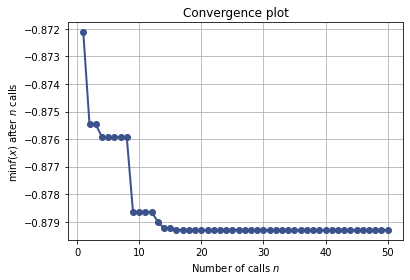

In [ ]:
def train_func(params):
    """ training funcion that will be optimised """
    learning_rate = params[0]
    max_depth = params[1]
    min_child_weight=params[2]
    subsample = params[3]
    colsample_bynode = params[4]
    num_parallel_tree = params[5]
    print(f"Testing parameters: {params}")
    
    scores = []
    for fold in range(5):
        train_data = X[X.fold != fold].copy()
        test_data = X[X.fold == fold].copy()
        X_train = train_data.drop(columns=['fold', 'y']).values
        X_test = test_data.drop(columns=['fold', 'y']).values
        y_train = train_data['y'].values
        y_test = test_data['y'].values

        
        fit_params = {
            'early_stopping_rounds': 100,
            'eval_metric' : 'auc',
            'eval_set': [(X_test, y_test)],
            'verbose': False,
        }

        xgb = XGBClassifier(
            n_jobs=-1,
            eval_metric='auc',
            random_state=0,
            n_estimators=100,  # you should tune n_estimators aswell
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bynode=colsample_bynode,
            num_parallel_tree=num_parallel_tree
        )
        
        xgb.fit(X_train, y_train, **fit_params)
        p = xgb.predict_proba(X_test)[:, -1]
        scores.append(roc_auc_score(y_test, p))
    avg_score = np.mean(scores)
    return -avg_score  # metric that will be minimized, since a bigger auc is better, we negate it

space = [
    (1e-3, 9e-1, 'log-uniform'),  # learning_rate
    (3, 30),  # max_depth
    (0.01, 20.0, 'log-uniform'),  # min_child_weight
    (0.2, 1.0),  # subsample
    (0.2, 1.0),  # colsample_bynode
    [1, 2, 3],  # num_parallel_tree
]

res_gp = forest_minimize(train_func, space, base_estimator='RF', random_state=42, verbose=1, n_calls=50, n_random_starts=10)
xgb_best_params = res_gp.x
print(f"Best found params: {xgb_best_params}") 
plot_convergence(res_gp);

In [ ]:
def xgb_learning_rate_decay_power_099(boosting_round, num_boost_round):
    base_learning_rate = xgb_best_params[0]
    lr = base_learning_rate  * np.power(.99, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_decay_power_0995(boosting_round, num_boost_round):
    base_learning_rate = xgb_best_params[0]
    lr = base_learning_rate  * np.power(.995, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_decay_power_095(boosting_round, num_boost_round):
    base_learning_rate = xgb_best_params[0]
    lr = base_learning_rate  * np.power(.95, boosting_round)
    return lr if lr > 1e-3 else 1e-3

# testing some default values
def xgb_learning_rate_010_decay_power_099(boosting_round, num_boost_round):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_010_decay_power_0995(boosting_round, num_boost_round):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_010_decay_power_095(boosting_round, num_boost_round):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.95, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_050_decay_power_099(boosting_round, num_boost_round):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_050_decay_power_0995(boosting_round, num_boost_round):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.995, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_050_decay_power_095(boosting_round, num_boost_round):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.95, boosting_round)
    return lr if lr > 1e-3 else 1e-3

In [ ]:
poss_cbs = {
    0: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_099)],
    1: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_0995)],
    2: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_095)],
    3: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_099)],
    4: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_0995)],
    5: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_095)],
    6: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_099)],
    7: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_0995)],
    8: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_095)]
}

In [ ]:
learning_rate = xgb_best_params[0]
max_depth = xgb_best_params[1]
min_child_weight = xgb_best_params[2]
subsample = xgb_best_params[3]
colsample_bynode = xgb_best_params[4]
num_parallel_tree = xgb_best_params[5]

poss_cbs = {
    0: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_099)],
    1: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_0995)],
    2: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_095)],
    3: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_099)],
    4: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_0995)],
    5: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_095)],
    6: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_099)],
    7: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_0995)],
    8: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_095)]
}

# trying different lr decay callbacks
best_cb = None
best_score = 0
for cb in poss_cbs:
    scores = []
    for fold in range(5):
        train_data = X[X.fold != fold].copy()
        test_data = X[X.fold == fold].copy()
        X_train = train_data.drop(columns=['fold', 'y']).values
        X_test = test_data.drop(columns=['fold', 'y']).values
        y_train = train_data['y'].values
        y_test = test_data['y'].values

        fit_params = {
            'early_stopping_rounds': 1000,
            'eval_metric' : 'auc',
            'eval_set': [(X_test, y_test)],
            'callbacks': poss_cbs[cb],
            'verbose': False,
        }

        xgb = XGBClassifier(
            n_jobs=-1,
            eval_metric='auc',
            random_state=0,
            n_estimators=100,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bynode=colsample_bynode,
            num_parallel_tree=num_parallel_tree
        )

        xgb.fit(X_train, y_train, **fit_params)
        p = xgb.predict_proba(X_test)[:, -1]
        scores.append(roc_auc_score(y_test, p))
    avg_score = np.mean(scores)
    print(f"Callback: {cb}, auc = {round(avg_score, 4)}")
    if avg_score > best_score:
        best_score = avg_score
        best_cb = cb

Callback: 0, auc = 0.8789
Callback: 1, auc = 0.8789
Callback: 2, auc = 0.878
Callback: 3, auc = 0.879
Callback: 4, auc = 0.8792
Callback: 5, auc = 0.8783
Callback: 6, auc = 0.8788
Callback: 7, auc = 0.8789
Callback: 8, auc = 0.8778


In [ ]:
cross_val_probas = []
ground_truths = []
for fold in range(5):
    train_data = X[X.fold != fold].copy()
    test_data = X[X.fold == fold].copy()
    X_train = train_data.drop(columns=['fold', 'y']).values
    X_test = test_data.drop(columns=['fold', 'y']).values
    y_train = train_data['y'].values
    y_test = test_data['y'].values

    fit_params = {
        'early_stopping_rounds': 1000,
        'eval_metric' : 'auc',
        'eval_set': [(X_test, y_test)],
        'callbacks': poss_cbs[best_cb],
        'verbose': False,
    }

    xgb = XGBClassifier(
        n_jobs=-1,
        eval_metric='auc',
        random_state=0,
        n_estimators=100,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bynode=colsample_bynode,
        num_parallel_tree=num_parallel_tree
    )

    xgb.fit(X_train, y_train, **fit_params)
    p = xgb.predict_proba(X_test)[:, -1]
    cross_val_probas += p.tolist()
    ground_truths += y_test.tolist()

In [ ]:
best_th = 0
f1_max = 0
for th in np.linspace(0.1, 0.9, num=1000):
    f1 = f1_score(np.asarray(ground_truths), (np.asarray(cross_val_probas) >= th).astype(int))
    if f1_max < f1:
        f1_max = f1
        best_th = th
print(f"MAX F1 SCORE: {f1_max}, THRESHHOLD: {best_th}")

MAX F1 SCORE: 0.6699081577525662, THRESHHOLD: 0.3138138138138138


In [ ]:
Xtr = X.drop(columns=['fold', 'y']).values
y_train = X['y'].values

In [ ]:
X.drop(columns=['fold', 'y'])

,13/xgb_0.08897304937326753_3_0.01_0.7714543769188138_1.0_3_807.pkl.z,13/lgbm_837_184_646_0.006173770394704579.pkl.z,13/xgb_0.09888723775988947_3_20.0_0.6757221174622041_0.2_3_1000.pkl.z,13/xgb_0.058648106702951834_30_0.01_0.2_0.2_1_1000.pkl.z,13/nn_273_69_33_4.649617447336329e-05.pkl.z,13/xgb_0.0012373913042111905_26_0.30524733778066404_0.5161201888014517_0.9413270926350357_2_394.pkl.z
0,0.326157,0.414983,0.353322,0.185289,0.0,0.490295
1,0.812008,0.844535,0.781035,0.591186,1.0,0.522577
2,0.232265,0.226648,0.271295,0.171816,0.0,0.484115
3,0.096657,0.101329,0.095477,0.034453,0.0,0.479617
4,0.073478,0.072586,0.076224,0.055732,0.0,0.482467
...,...,...,...,...,...,...
5645,0.063992,0.070950,0.063082,0.015106,0.0,0.479817
5646,0.054265,0.067179,0.048748,0.051423,0.0,0.479753
5647,0.027621,0.041059,0.024112,0.029176,0.0,0.476412
5648,0.370194,0.491129,0.342525,0.155469,1.0,0.499482


In [ ]:
X_test = X_test[selected_xg].copy()
Xtr = X.drop(columns=['fold', 'y'])
y_train = X['y'].values

fit_params = {
    'eval_metric' : 'auc',
    'callbacks': poss_cbs[best_cb],
    'verbose': False,
}
xgb = XGBClassifier(
    n_jobs=-1,
    eval_metric='auc',
    random_state=42,
    n_estimators=100,
    learning_rate=learning_rate,
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    subsample=subsample,
    colsample_bynode=colsample_bynode,
    num_parallel_tree=num_parallel_tree
)

xgb.fit(Xtr, y_train, **fit_params)
p = xgb.predict_proba(X_test)[:, -1]
preds = (p >= best_th).astype(int)

In [ ]:
pd.DataFrame({'id': test_id, 'predicted': preds}).to_csv(PATH + '/Submissions/stack_xgboost_approachs2.csv', index=False)

## Features Analysis

In [ ]:
class FeatureImportance_:

    def __init__(self):
        self.feature_selection = None

    def result(self, X, y):

        print("Variable Importance")
        clf = RandomForestClassifier(max_depth=2, random_state=42)

        clf.fit(X, y)

        res_var_imp = pd.DataFrame({
            "feature": X.columns,
            "var_imp": clf.feature_importances_
        })

        print("Mutual Information")
        mutual_info = mutual_info_classif(X, y)
        res_mutual_info = pd.DataFrame({
            "feature": X.columns,
            "mutual_info": mutual_info
        })

        print("Zero Proportion")
        res_pzeros = pd.DataFrame({
            "feature": X.columns,
            "pzeros": (X.shape[0] - X.astype(bool).sum(axis=0)) / X.shape[0] * 100
        })

        print("Null proporcion")
        res_pnull = pd.DataFrame({
            "feature": X.columns,
            "pnull": 100 - (X.shape[0] - X.replace(-999, np.nan).isnull().sum()) / X.shape[0] * 100
        })

        # print("Backward Feature Elimination")
        # lasso_newton = LogisticRegression(C=1, penalty="l2", solver='sag', tol = 0.1, random_state=42)
        # bfs = SequentialFeatureSelector(lasso_newton,
        #                                     direction='backward',
        #                                     scoring='f1',
        #                                     cv=2,
        #                                     n_jobs=-1)
        # bfs.fit(X, y)

        # res_bfs = pd.DataFrame({
        #     "feature": X.columns,
        #     "bfs": ["to_keep" if bfs.support_[i] else "to_remove" for i in range(X.columns.shape[0])]
        # })


        print("Lasso Regularization (L1)")
        lasso = LogisticRegression(C=1, penalty="l1", solver="liblinear", random_state=314).fit(X, y)
        lasso_selector = SelectFromModel(lasso, prefit=True, threshold="median")

        res_lasso = pd.DataFrame({
            "feature": X.columns,
            "lasso": np.where(lasso_selector.get_support(), "to_keep", "to_remove")
        })

        # print("RFE")
        # rf = RandomForestClassifier(n_jobs=-1, max_depth=4)
        # rfe_selector = RFECV(rf, min_features_to_select=20, step=1, n_jobs=1, verbose=1)
        # rfe_selector.fit(X.values, y)

        # res_rfe = pd.DataFrame({
        #     "feature": X.columns,
        #     "rfe": np.where(rfe_selector.support_, "to_keep", "to_remove")
        # })

        # print("Boruta")
        # rf = RandomForestClassifier(n_jobs=-1, max_depth=4)
        # boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=314)
        # boruta_selector.fit(X.values, y)

        # res_boruta = pd.DataFrame({
        #     "feature": X.columns,
        #     "boruta": np.where(boruta_selector.support_, "to_keep", "to_remove")
        # })

        print("Random Column")
        X_random = X.copy()
        X_random['random'] = np.random.uniform(0.0, 100.0, size=X.shape[0])

        rf = RandomForestClassifier(n_jobs=-1, max_depth=3)
        rf.fit(X_random, y)

        varip_random = np.float(rf.feature_importances_[X_random.columns=="random"])

        res_rand_var_imp = pd.DataFrame({
            "feature": X_random.columns,
            "rand_var_imp": rf.feature_importances_,
            "rand_var": np.where(rf.feature_importances_ > varip_random, "to_keep", "to_remove")
        })
# merge(res_bfs).\ merge(res_rfe).\ merge(res_boruta).\
        feature_selection = res_var_imp.\
                                merge(res_mutual_info).\
                                merge(res_pzeros).\
                                merge(res_pnull).\
                                merge(res_lasso).\
                                merge(res_rand_var_imp.drop('rand_var_imp', axis=1))

        return feature_selection.style.\
                bar(subset=['var_imp'],color='#205ff2').\
                bar(subset=['mutual_info'],color='#205ff2').\
                background_gradient(subset=['pzeros'],cmap='coolwarm').\
                background_gradient(subset=['pnull'],cmap='coolwarm').\
                apply(lambda x: ["background: red" if v == "to_remove" else "" for v in x], axis = 1)

In [ ]:
X = pd.concat([X_train, X_valid], axis=0)
y = pd.concat([y_train, y_valid], axis=0)
ftr_impo = FeatureImportance_()

ftr_impo.result(X, y)

Variable Importance
Mutual Information
Zero Proportion
Null proporcion
Lasso Regularization (L1)
Random Column
